In [1]:
# Import necessary library
import pandas as pd
from pandas.plotting import parallel_coordinates
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from factor_analyzer import Rotator
from scipy.stats import gmean

In [2]:
# Import data
merged_idn =  gpd.read_file("../data/merged_idn/merged_idn.shp")

In [3]:
merged_idn.columns

Index(['KECAMATAN', 'KAB_KOTA', 'PROVINSI', 'pds_bank', 'pds_kopera', 'pds_sd',
       'pds_smp', 'pds_sma', 'pds_polind', 'pds_posyan', 'pds_puskes',
       'pds_apotek', 'pds_cacat', 'pds_longso', 'pds_banjir', 'pds_banj_1',
       'pds_kebaka', 'pds_kekeri', 'pds_cemar1', 'pds_cemar2', 'pds_cemar3',
       'pds_minumb', 'pds_credit', 'pds_trayek', 'pds_road', 'pds_sinyal',
       'pds_warnet', 'pds_market', 'pds_toko', 'pds_fcook', 'pds_agentk',
       'pds_hhagr', 'pds_kelahi', 'pds_anakja', 'p0_gkn', 'se_p0_gkn',
       'p1_gkn', 'se_p1_gkn', 'p2_gkn', 'se_p2_gkn', 'p0_intl', 'se_p0_intl',
       'p1_intl', 'se_p1_intl', 'p2_intl', 'se_p2_intl', 'gini', 'se_gini',
       'ADM3_PCODE', 'PRIA', 'JUMLAH_PEN', 'LUAS_WILAY', 'KEPADATAN', 'WANITA',
       'TIDAK_BELU', 'BELUM_TAMA', 'BELUM_TIDA', 'underage', 'oldies',
       'geometry'],
      dtype='object')

In [4]:
# Group variables to dimensions
Economic = ['p0_gkn', 'p1_gkn', 'p2_gkn', 'gini', 'pds_kopera', 'pds_credit', 'BELUM_TIDA']
Cultural = ['TIDAK_BELU', 'BELUM_TAMA']
Gender = ['WANITA']
Community = ['pds_kelahi']
Health_wellbeing = ['underage', 'oldies', 'pds_cacat',]
Built_environment = ['pds_trayek', 'pds_road', 'pds_sinyal', 'pds_sd', 'pds_banjir', 'pds_banj_1', 'pds_minumb', 'pds_puskes']

In [5]:
# Remove null values
to_analyse = merged_idn.dropna()

## Economy

In [6]:
# Filter variables for economy dimension
to_analyse_econ = to_analyse[Economic]

In [7]:
# Standardise the value input
sv_PCA_econ = to_analyse_econ
ss = StandardScaler()
sv_PCA_std_econ = ss.fit_transform(sv_PCA_econ)

pca_test_econ = PCA()
pca_test_econ.fit(sv_PCA_std_econ)

PCA()

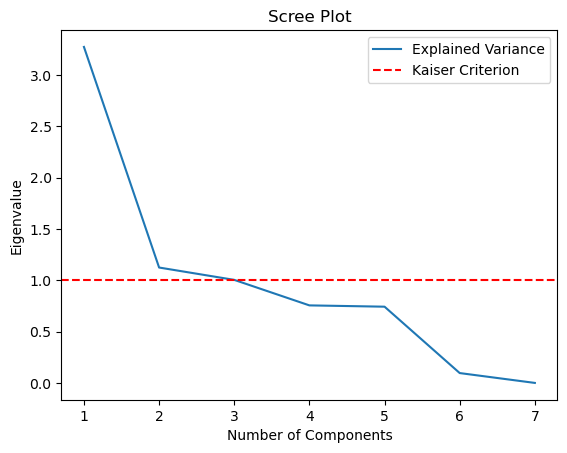

In [8]:
# Plot the Scree plot to get the number of components
plt.plot(range (1 , len (pca_test_econ.explained_variance_) + 1), pca_test_econ.explained_variance_, label ='Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.axhline(y =1 , color ='r', linestyle ='--', label ='Kaiser Criterion') 

# Kaiser criterion line
plt.legend ( loc ='best')
plt.show ()

In [9]:
# Filter components using Kaiser Criterion
n_components = sum(pca_test_econ.explained_variance_ >1)
print(n_components)

# Perform PCA with n_components number
pca_econ = PCA(n_components=n_components)
pca_scores_econ = pca_econ.fit_transform(sv_PCA_std_econ)

# Perform Rotator using varimax method
rotator = Rotator(method='varimax')
pca_scores_econ = rotator.fit_transform(pca_scores_econ)

3


In [10]:
# Create variables loadings DataFrame
loadings = pca_econ.components_
loadings_df_econ = pd.DataFrame(loadings, columns=Economic).T
loadings_df_econ

,0,1,2
p0_gkn,0.525736,0.125398,0.123001
p1_gkn,0.533289,0.227678,0.031255
p2_gkn,0.513747,0.274841,-0.008598
gini,-0.071619,0.438341,-0.830971
pds_kopera,-0.153707,0.586890,0.487524
pds_credit,-0.287582,0.295710,0.234660
BELUM_TIDA,-0.252607,0.482569,-0.023712


In [11]:
# Variance explained by each component
variance_explained_econ = pca_econ.explained_variance_ratio_

# Print or store the variance explained by each component
total_variance_explained_econ = sum(variance_explained_econ)
print(f"Total Variance Explained: {total_variance_explained_econ:.2f}")

for i, var in enumerate(variance_explained_econ):
    print(f"Variance explained by PC{i}: {var:.2f}")

Total Variance Explained: 0.77
Variance explained by PC0: 0.47
Variance explained by PC1: 0.16
Variance explained by PC2: 0.14


In [12]:
# Find the dominant factor for each factor
for factor in loadings_df_econ.columns :
    print(f"Factor_{factor + 1}:")
    high_loadings = loadings_df_econ[factor].abs()>0.5# Change the threshold as needed
    print(loadings_df_econ[high_loadings][factor])

Factor_1:
p0_gkn    0.525736
p1_gkn    0.533289
p2_gkn    0.513747
Name: 0, dtype: float64
Factor_2:
pds_kopera    0.58689
Name: 1, dtype: float64
Factor_3:
gini   -0.830971
Name: 2, dtype: float64


In [13]:
# Create DataFrame for Economy Index
index_econ = pd.DataFrame (pca_scores_econ, columns =['Factor_1', 'Factor_2', 'Factor_3'])

# Measure economy index according to the cardinality adjustments
index_econ['Total_Econ_Score'] = index_econ['Factor_1'] - index_econ['Factor_2'] - index_econ['Factor_3']

In [14]:
# Normalise Economy Index score with MinMax normalisation
min_score_econ = index_econ['Total_Econ_Score'].min()
max_score_econ = index_econ['Total_Econ_Score'].max()
index_econ['normalised_Econ_score'] = (index_econ['Total_Econ_Score']-min_score_econ)/(max_score_econ - min_score_econ)
index_econ = pd.concat([index_econ, to_analyse], axis =1)
Geo_econ = gpd.GeoDataFrame(index_econ, geometry=index_econ['geometry'])

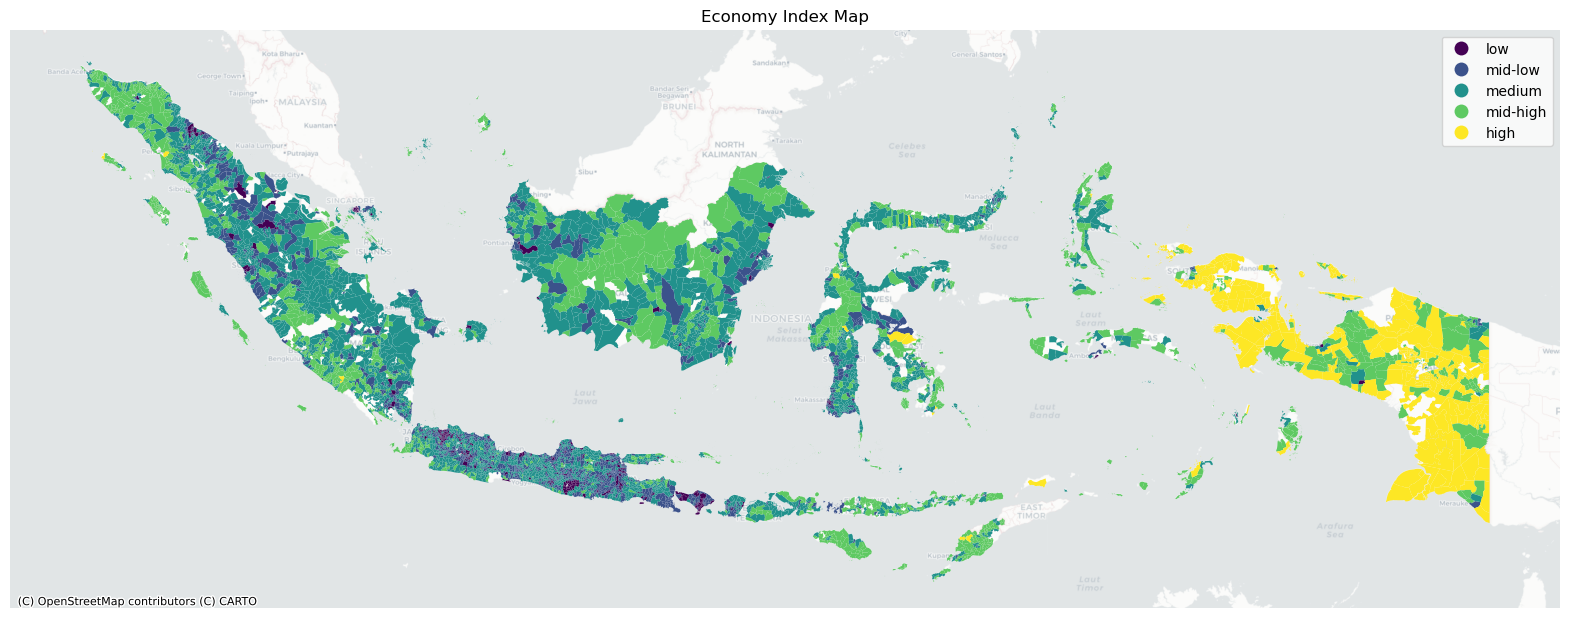

Category Counts:
low          317
mid-low     1271
medium      3032
mid-high    1488
high         338
Name: category, dtype: int64


In [15]:
# Define the standard deviation and mean
std_dev = Geo_econ['normalised_Econ_score'].std()
mean = Geo_econ['normalised_Econ_score'].mean()

# Define the category thresholds
thresholds = [-float("inf"), mean - 1.5 * std_dev, mean - 0.5 * std_dev, mean + 0.5 * std_dev, mean + 1.5 * std_dev, float("inf")]

# Define category labels
labels = ['low', 'mid-low', 'medium', 'mid-high', 'high']

# Categorize the data
Geo_econ['category'] = pd.cut(Geo_econ['normalised_Econ_score'], bins=thresholds, labels=labels)

# Count the number of occurrences for each category
category_counts = Geo_econ['category'].value_counts()
category_counts = category_counts[['low', 'mid-low', 'medium', 'mid-high', 'high']]

Geo_econ = Geo_econ.set_crs(epsg=4326)
Geo_econ = Geo_econ.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
Geo_econ.plot(column='category', cmap='viridis', legend=True, ax=ax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.7)

plt.title('Economy Index Map')
plt.axis('off')
plt.show()

print("Category Counts:")
print(category_counts)

## Built Environment

In [16]:
# Filter variables for built environment dimension
to_analyse_be = to_analyse[Built_environment]

In [17]:
# Standardise the value input
sv_PCA_be = to_analyse_be
ss = StandardScaler()
sv_PCA_std_be = ss.fit_transform(sv_PCA_be)

pca_test_be = PCA()
pca_test_be.fit(sv_PCA_std_be)

PCA()

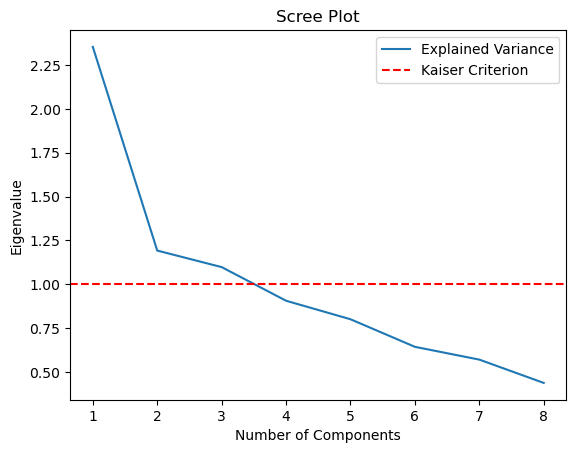

In [18]:
# Plot the Scree plot to get the number of components
plt.plot(range (1, len(pca_test_be.explained_variance_ )+1), pca_test_be.explained_variance_, label='Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.axhline(y =1 , color ='r', linestyle ='--', label ='Kaiser Criterion') 

# Kaiser criterion line
plt.legend ( loc ='best')
plt.show ()

In [19]:
# Filter components using Kaiser Criterion
n_components = sum(pca_test_be.explained_variance_ >0.9) # We adjust it to 0.9 minimum eigenvalues to get more variance total factor in the model
print(n_components)

# Perform PCA with n_components number
pca_be = PCA(n_components=n_components)
pca_scores_be = pca_be.fit_transform(sv_PCA_std_be)

# Perform Rotator using varimax method
rotator = Rotator(method='varimax')
pca_scores_be = rotator.fit_transform(pca_scores_be)

4


In [20]:
# Create variables loadings DataFrame
loadings = pca_be.components_
loadings_df_be = pd.DataFrame(loadings, columns=Built_environment).T
loadings_df_be

,0,1,2,3
pds_trayek,-0.403851,-0.193070,0.048072,-0.163170
pds_road,-0.503159,-0.250448,-0.006682,0.016871
pds_sinyal,-0.483017,-0.038381,0.066516,-0.035817
pds_sd,-0.429518,0.408197,-0.114175,0.102045
pds_banjir,-0.076387,0.182471,0.678844,-0.654409
pds_banj_1,-0.017730,-0.045720,0.702490,0.705286
pds_minumb,-0.334950,-0.381721,-0.118894,0.099396
pds_puskes,-0.218182,0.742163,-0.108290,0.160735


In [21]:
# Variance explained by each component
variance_explained_be = pca_be.explained_variance_ratio_

# Print or store the variance explained by each component
total_variance_explained_be = sum(variance_explained_be)
print(f"Total Variance Explained: {total_variance_explained_be:.2f}")

for i, var in enumerate(variance_explained_be):
    print(f"Variance explained by PC{i}: {var:.2f}")

Total Variance Explained: 0.69
Variance explained by PC0: 0.29
Variance explained by PC1: 0.15
Variance explained by PC2: 0.14
Variance explained by PC3: 0.11


In [22]:
# Find the dominant variables for each factor
for factor in loadings_df_be.columns :
    print(f"Factor_{factor + 1}:")
    high_loadings = loadings_df_be[factor].abs()>0.5# Change the threshold as needed
    print(loadings_df_be[high_loadings][factor])

Factor_1:
pds_road   -0.503159
Name: 0, dtype: float64
Factor_2:
pds_puskes    0.742163
Name: 1, dtype: float64
Factor_3:
pds_banjir    0.678844
pds_banj_1    0.702490
Name: 2, dtype: float64
Factor_4:
pds_banjir   -0.654409
pds_banj_1    0.705286
Name: 3, dtype: float64


In [23]:
# Create DataFrame for Economy Index
index_be = pd.DataFrame (pca_scores_be, columns =['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4'])

# Measure economy index according the cardinality adjustments
index_be['Total_BE_Score'] = index_be['Factor_1'] - index_be['Factor_2'] + index_be['Factor_3'] + index_be['Factor_4']

In [24]:
# Normalise the built environment index
min_score_be = index_be['Total_BE_Score'].min()
max_score_be = index_be['Total_BE_Score'].max()
index_be['normalised_BE_score'] = (index_be['Total_BE_Score']-min_score_be)/(max_score_be - min_score_be)
index_be = pd.concat([index_be, to_analyse], axis =1)
Geo_be = gpd.GeoDataFrame(index_be, geometry=index_be['geometry'])

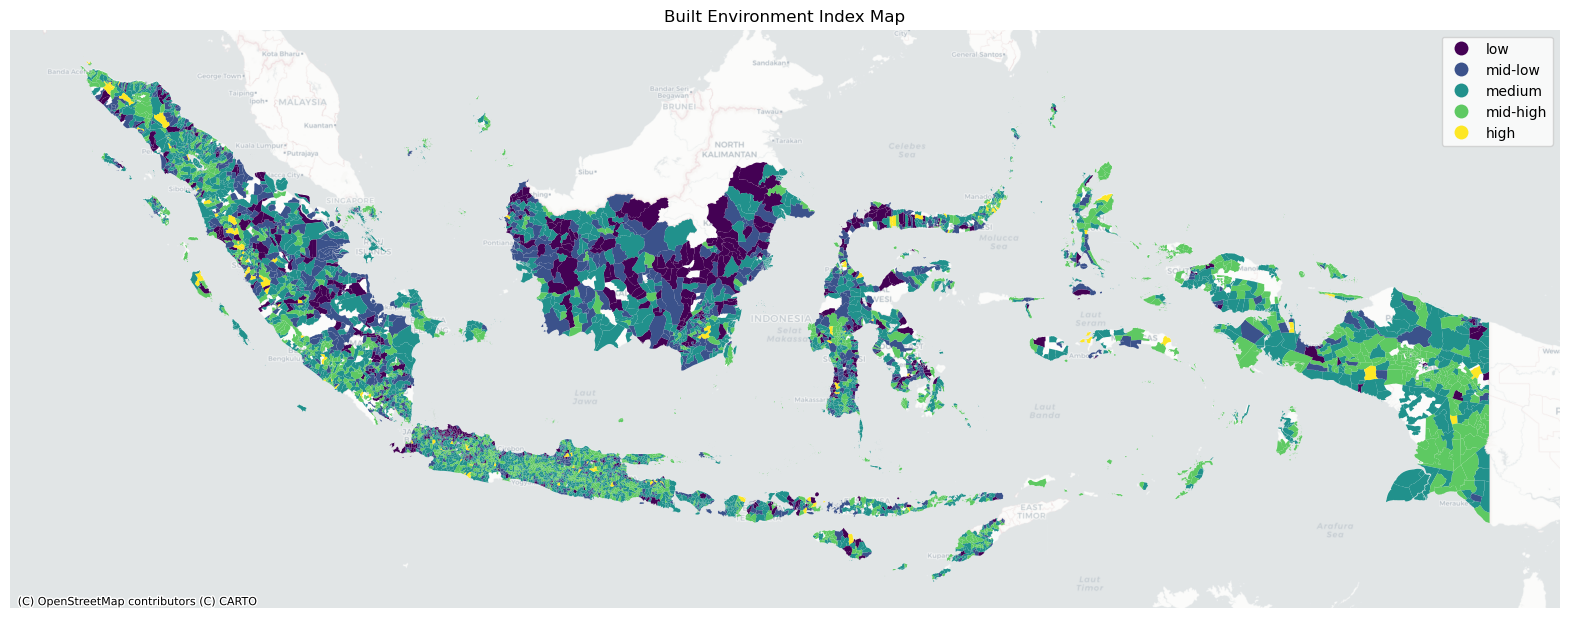

Category Counts:
low          607
mid-low     1021
medium      2570
mid-high    2126
high         122
Name: category, dtype: int64


In [25]:
# Define the standard deviation and mean
std_dev = Geo_be['normalised_BE_score'].std()
mean = Geo_be['normalised_BE_score'].mean()

# Define the category thresholds
thresholds = [-float("inf"), mean - 1.5 * std_dev, mean - 0.5 * std_dev, mean + 0.5 * std_dev, mean + 1.5 * std_dev, float("inf")]

# Define category labels
labels = ['low', 'mid-low', 'medium', 'mid-high', 'high']

# Categorize the data
Geo_be['category'] = pd.cut(Geo_be['normalised_BE_score'], bins=thresholds, labels=labels)

# Count the number of occurrences for each category
category_counts = Geo_be['category'].value_counts()
category_counts = category_counts[['low', 'mid-low', 'medium', 'mid-high', 'high']]

Geo_be = Geo_be.set_crs(epsg=4326)
Geo_be = Geo_be.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
Geo_be.plot(column='category', cmap='viridis', legend=True, ax=ax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.7)

plt.title('Built Environment Index Map')
plt.axis('off')
plt.show()

print("Category Counts:")
print(category_counts)

## Health & Well-being

In [26]:
# Filter variables for health & well-being dimension
to_analyse_hwb = to_analyse[Health_wellbeing]

In [27]:
# Standardise the value input
sv_PCA_hwb = to_analyse_hwb
ss = StandardScaler()
sv_PCA_std_hwb = ss.fit_transform(sv_PCA_hwb)

pca_test_hwb = PCA()
pca_test_hwb.fit(sv_PCA_std_hwb)

PCA()

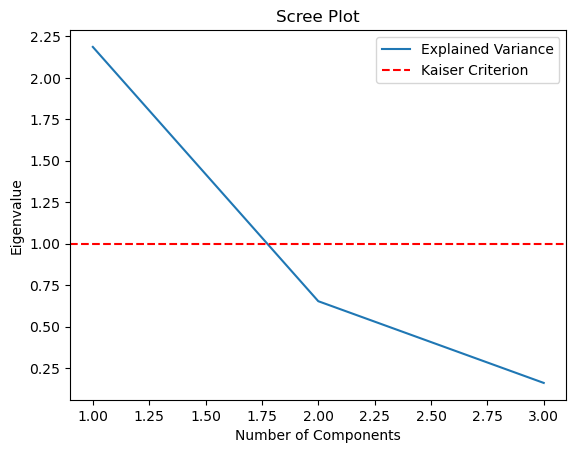

In [28]:
# Plot the Scree plot to get the number of components
plt.plot(range(1, len(pca_test_hwb.explained_variance_)+1), pca_test_hwb.explained_variance_, label ='Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.axhline(y =1 , color ='r', linestyle ='--', label ='Kaiser Criterion') 

# Kaiser criterion line
plt.legend ( loc ='best')
plt.show ()

In [29]:
# Filter components using Kaiser Criterion
n_components_hwb = sum(pca_test_hwb.explained_variance_ >1)
print(n_components_hwb)

# Perform PCA with n_components number
pca_hwb = PCA(n_components=n_components_hwb)
pca_scores_hwb = pca_hwb.fit_transform(sv_PCA_std_hwb)

1


In [30]:
# Create variables loadings DataFrame
loadings_hwb = pca_hwb.components_
loadings_df_hwb = pd.DataFrame(loadings_hwb, columns=Health_wellbeing).T
loadings_df_hwb

,0
underage,0.584624
oldies,0.639812
pds_cacat,0.498854


In [31]:
# Variance explained by each component
variance_explained = pca_hwb.explained_variance_ratio_

# Print or store the variance explained by each component
total_variance_explained = sum(variance_explained)
print(f"Total Variance Explained: {total_variance_explained:.2f}")

for i, var in enumerate(variance_explained):
    print(f"Variance explained by PC{i}: {var:.2f}")

Total Variance Explained: 0.73
Variance explained by PC0: 0.73


In [32]:
# Find the dominant variables for each factor
for factor in loadings_df_hwb.columns :
    print(f"Factor_{factor+1}:")
    high_loadings = loadings_df_hwb[factor].abs()>0.1# Change the threshold as needed
    print(loadings_df_hwb[high_loadings][factor])

Factor_1:
underage     0.584624
oldies       0.639812
pds_cacat    0.498854
Name: 0, dtype: float64


In [36]:
# Create DataFrame for Health & Wellbeing Index
index_hwb = pd.DataFrame (pca_scores_hwb, columns =['Factor_1'])

# Use the factor as Health & Wellbeing index
index_hwb['HWB_Score'] = index_hwb['Factor_1']

In [37]:
# Normalise Economy Index score with MinMax normalisation
min_score_hwb = index_hwb['HWB_Score'].min()
max_score_hwb = index_hwb['HWB_Score'].max()
index_hwb['normalised_HWB_score'] = (index_hwb['HWB_Score']-min_score_hwb)/(max_score_hwb - min_score_hwb)
index_hwb = pd.concat([index_hwb, to_analyse], axis =1)

Geo_hwb = gpd.GeoDataFrame(index_hwb, geometry=index_hwb['geometry'])

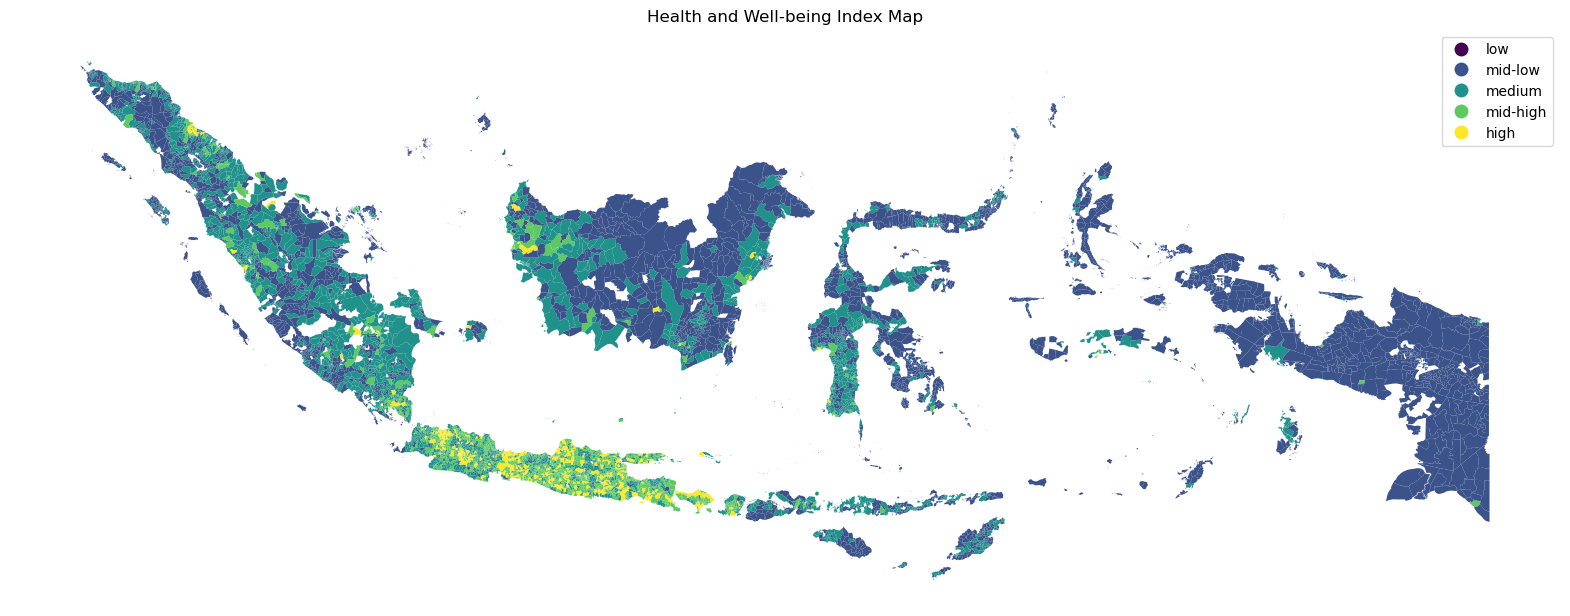

Category Counts:
low            0
mid-low     2542
medium      2231
mid-high    1139
high         534
Name: category, dtype: int64


In [38]:
# Define the standard deviation and mean
std_dev = Geo_hwb['normalised_HWB_score'].std()
mean = Geo_hwb['normalised_HWB_score'].mean()

# Define the category thresholds
thresholds = [-float("inf"), mean - 1.5 * std_dev, mean - 0.5 * std_dev, mean + 0.5 * std_dev, mean + 1.5 * std_dev, float("inf")]

# Define category labels
labels = ['low', 'mid-low', 'medium', 'mid-high', 'high']

# Categorize the data
Geo_hwb['category'] = pd.cut(Geo_hwb['normalised_HWB_score'], bins=thresholds, labels=labels)

# Count the number of occurrences for each category
category_counts = Geo_hwb['category'].value_counts()
category_counts = category_counts[['low', 'mid-low', 'medium', 'mid-high', 'high']]

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
Geo_hwb.plot(column='category', cmap='viridis', legend=True, ax=ax)
plt.title('Health and Well-being Index Map')
plt.axis('off')
plt.show()

print("Category Counts:")
print(category_counts)

## Cultural

In [106]:
# Filter variables for cultural dimension
to_analyse_cul = to_analyse[Cultural]

In [107]:
# Find outlier using standard deviation
mean = to_analyse_cul['TIDAK_BELU'].mean()
std_dev = to_analyse_cul['TIDAK_BELU'].std()
upper_bound = mean + 3 * std_dev

# Create n_school index
to_analyse_cul['n_school_index'] = to_analyse_cul['TIDAK_BELU']/upper_bound

# Find outlier using standard deviation
mean = to_analyse_cul['BELUM_TAMA'].mean()
std_dev = to_analyse_cul['BELUM_TAMA'].std()
upper_bound = mean + 3 * std_dev

# Create nf_school index
to_analyse_cul['nf_school_index'] = to_analyse_cul['BELUM_TAMA']/upper_bound

# Mean
to_analyse_cul['mean'] = to_analyse_cul[['n_school_index', 'nf_school_index']].mean(axis=1)

C:\Users\Haekal Akbar\AppData\Local\Temp\ipykernel_6676\222131615.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_analyse_cul['n_school_index'] = to_analyse_cul['TIDAK_BELU']/upper_bound
C:\Users\Haekal Akbar\AppData\Local\Temp\ipykernel_6676\222131615.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_analyse_cul['nf_school_index'] = to_analyse_cul['BELUM_TAMA']/upper_bound
C:\Users\Haekal Akbar\AppData\Local\Temp\ipykernel_6676\222131615.py:18: SettingWithCopyWarning: 
A value is trying to be 

In [108]:
# Transform into GeoDataFrame for mapping
to_analyse_cul = pd.concat([to_analyse_cul, merged_idn['geometry']], axis=1)
to_analyse_cul = gpd.GeoDataFrame(to_analyse_cul, geometry=to_analyse_cul['geometry'])

# Calculate the geometric mean
to_analyse_cul['cultural_index'] = gmean(to_analyse_cul[['n_school_index', 'nf_school_index']], axis=1)

In [109]:
# Normalise value
min_score_cul = to_analyse_cul['cultural_index'].min()
max_score_cul = to_analyse_cul['cultural_index'].max()
to_analyse_cul['normalised_cul_index'] = (to_analyse_cul['cultural_index']-min_score_gend)/(max_score_gend - min_score_gend)

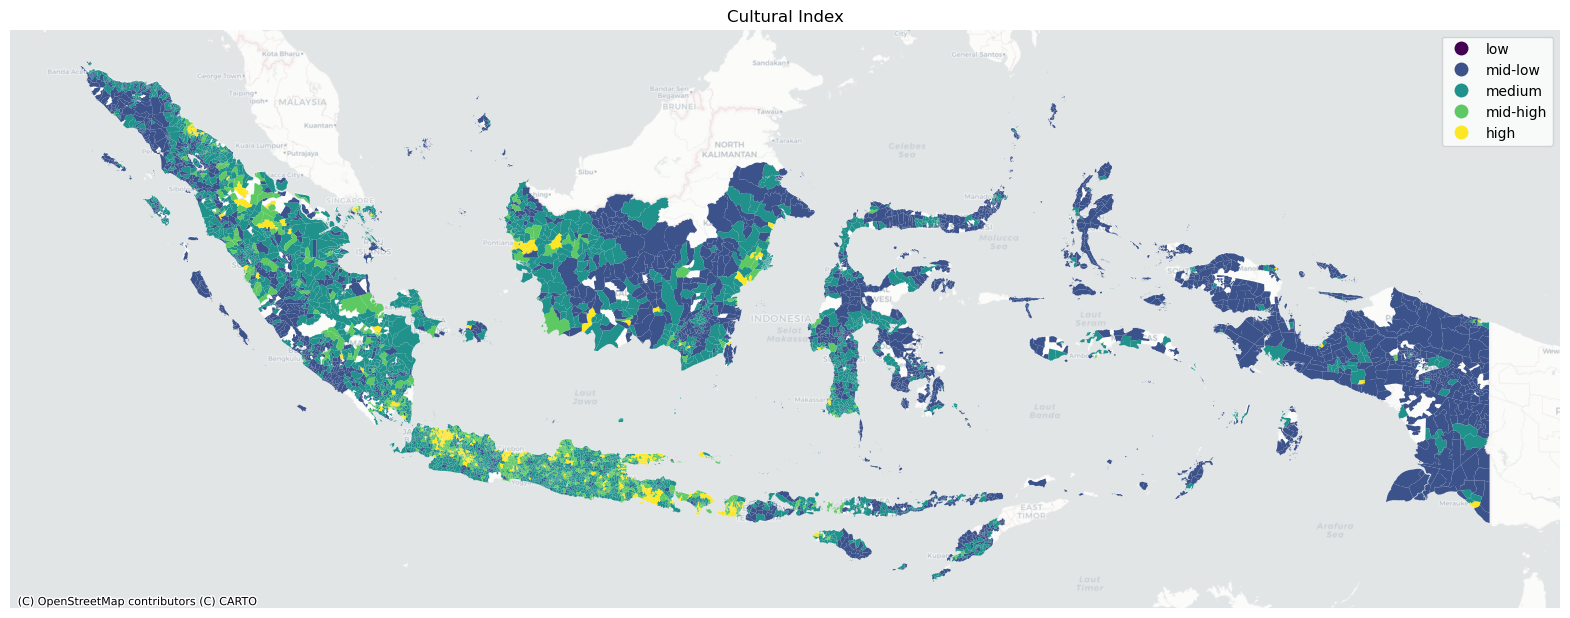

Category Counts:
low            0
mid-low     2354
medium      2777
mid-high     901
high         414
Name: category, dtype: int64


In [110]:
# Define the standard deviation and mean
std_dev = to_analyse_cul['normalised_cul_index'].std()
mean = to_analyse_cul['normalised_cul_index'].mean()

# Define the category thresholds
thresholds = [-float("inf"), mean - 1.5 * std_dev, mean - 0.5 * std_dev, mean + 0.5 * std_dev, mean + 1.5 * std_dev, float("inf")]

# Define category labels
labels = ['low', 'mid-low', 'medium', 'mid-high', 'high']

# Categorize the data
to_analyse_cul['category'] = pd.cut(to_analyse_cul['normalised_cul_index'], bins=thresholds, labels=labels)

to_analyse_cul = to_analyse_cul.set_crs(epsg=4326)
to_analyse_cul = to_analyse_cul.to_crs(epsg=3857)

# Count the number of occurrences for each category
category_counts = to_analyse_cul['category'].value_counts()
category_counts = category_counts[['low', 'mid-low', 'medium', 'mid-high', 'high']]

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
to_analyse_cul.plot(column='category', cmap='viridis', legend=True, ax=ax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.7)

plt.title('Cultural Index')
plt.axis('off')
plt.show()

print("Category Counts:")
print(category_counts)

## Gender

In [111]:
# Filter variables for gender dimension
to_analyse_gend = to_analyse[Gender]

In [112]:
# Find outlier using standard deviation
mean = to_analyse_gend['WANITA'].mean()
std_dev = to_analyse_gend['WANITA'].std()
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

# Create gender index
to_analyse_gend['gender_index'] = to_analyse_gend['WANITA']/upper_bound

C:\Users\Haekal Akbar\AppData\Local\Temp\ipykernel_6676\3884191679.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_analyse_gend['gender_index'] = to_analyse_gend['WANITA']/upper_bound


In [113]:
# Normalise the index value
min_score_gend = to_analyse_gend['gender_index'].min()
max_score_gend = to_analyse_gend['gender_index'].max()
to_analyse_gend['normalised_gend_index'] = (to_analyse_gend['gender_index']-min_score_gend)/(max_score_gend - min_score_gend)

C:\Users\Haekal Akbar\AppData\Local\Temp\ipykernel_6676\540625888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_analyse_gend['normalised_gend_index'] = (to_analyse_gend['gender_index']-min_score_gend)/(max_score_gend - min_score_gend)


In [114]:
# Transform into GeoDataFrame for mapping
to_analyse_gend = pd.concat([to_analyse_gend, merged_idn['geometry']], axis=1)
to_analyse_gend = gpd.GeoDataFrame(to_analyse_gend, geometry=to_analyse_gend['geometry'])

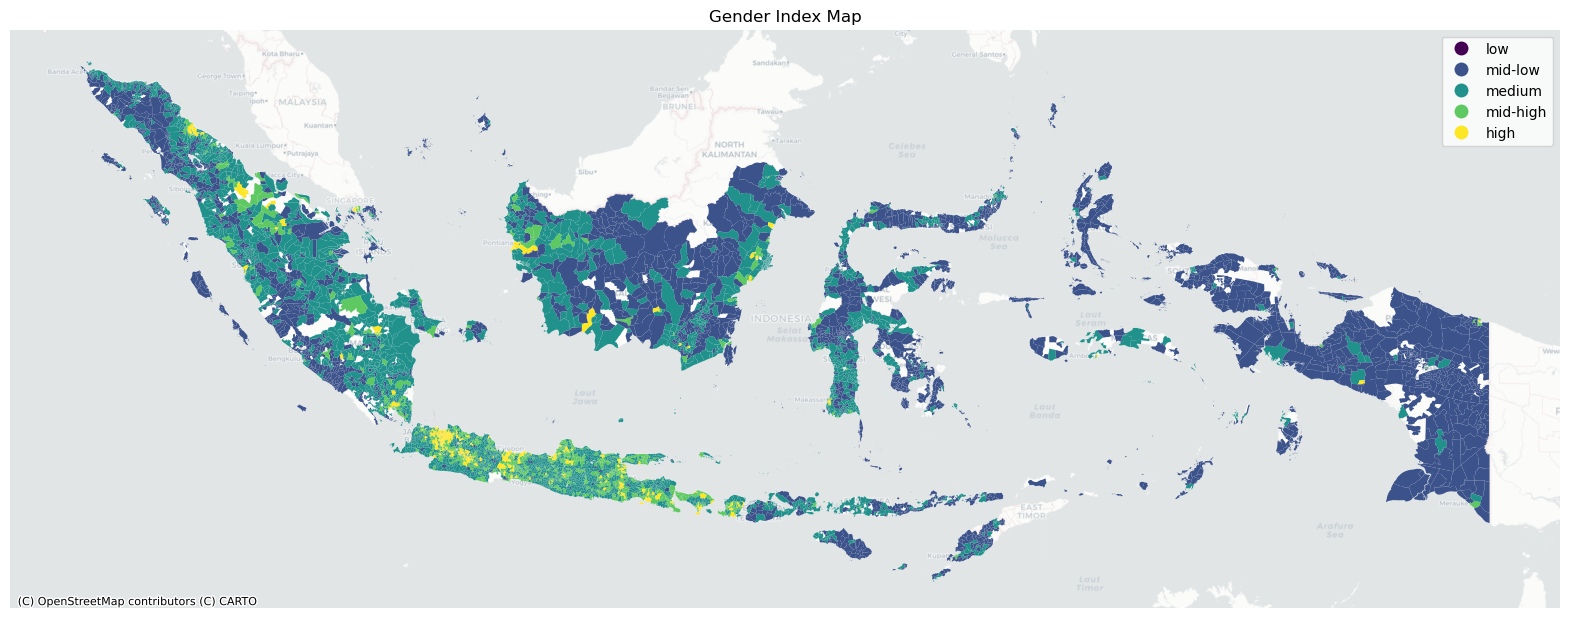

Category Counts:
low            0
mid-low     2362
medium      2794
mid-high     904
high         386
Name: category, dtype: int64


In [115]:
# Define the standard deviation and mean
std_dev = to_analyse_gend['normalised_gend_index'].std()
mean = to_analyse_gend['normalised_gend_index'].mean()

# Define the category thresholds
thresholds = [-float("inf"), mean - 1.5 * std_dev, mean - 0.5 * std_dev, mean + 0.5 * std_dev, mean + 1.5 * std_dev, float("inf")]

# Define category labels
labels = ['low', 'mid-low', 'medium', 'mid-high', 'high']

# Categorize the data
to_analyse_gend['category'] = pd.cut(to_analyse_gend['normalised_gend_index'], bins=thresholds, labels=labels)

# Count the number of occurrences for each category
category_counts = to_analyse_gend['category'].value_counts()
category_counts = category_counts[['low', 'mid-low', 'medium', 'mid-high', 'high']]

to_analyse_gend = to_analyse_gend.set_crs(epsg=4326)
to_analyse_gend = to_analyse_gend.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
to_analyse_gend.plot(column='category', cmap='viridis', legend=True, ax=ax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.7)

plt.title('Gender Index Map')
plt.axis('off')
plt.show()

print("Category Counts:")
print(category_counts)

## Community

In [116]:
# Filter variables for cultural dimension
to_analyse_comm = to_analyse[Community]

In [117]:
# Find outlier using standard deviation
mean = to_analyse_comm['pds_kelahi'].mean()
std_dev = to_analyse_comm['pds_kelahi'].std()
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

# Create gender index
to_analyse_comm['community_index'] = to_analyse_comm['pds_kelahi']/upper_bound

C:\Users\Haekal Akbar\AppData\Local\Temp\ipykernel_6676\1150521392.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_analyse_comm['community_index'] = to_analyse_comm['pds_kelahi']/upper_bound


In [118]:
# Normalise value
min_score_comm = to_analyse_comm['community_index'].min()
max_score_comm = to_analyse_comm['community_index'].max()
to_analyse_comm['normalised_comm_index'] = (to_analyse_comm['community_index']-min_score_comm)/(max_score_comm - min_score_comm)

C:\Users\Haekal Akbar\AppData\Local\Temp\ipykernel_6676\4083190754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_analyse_comm['normalised_comm_index'] = (to_analyse_comm['community_index']-min_score_comm)/(max_score_comm - min_score_comm)


In [119]:
# Transform into GeoDataFrame for mapping
to_analyse_comm = pd.concat([to_analyse_comm, merged_idn['geometry']], axis=1)
to_analyse_comm = gpd.GeoDataFrame(to_analyse_comm, geometry=to_analyse_comm['geometry'])

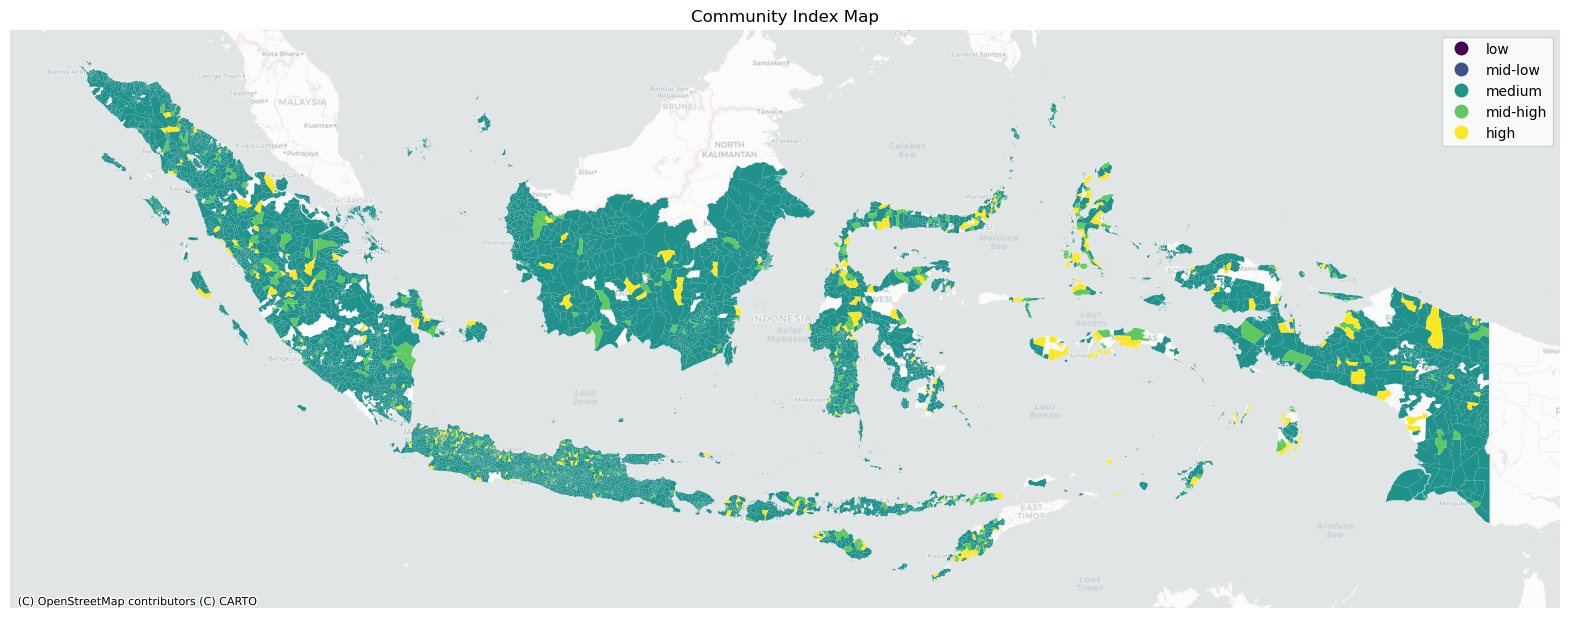

Category Counts:
low            0
mid-low        0
medium      5482
mid-high     522
high         442
Name: category, dtype: int64


In [120]:
# Define the standard deviation and mean
std_dev = to_analyse_comm['normalised_comm_index'].std()
mean = to_analyse_comm['normalised_comm_index'].mean()

# Define the category thresholds
thresholds = [-float("inf"), mean - 1.5 * std_dev, mean - 0.5 * std_dev, mean + 0.5 * std_dev, mean + 1.5 * std_dev, float("inf")]

# Define category labels
labels = ['low', 'mid-low', 'medium', 'mid-high', 'high']

# Categorize the data
to_analyse_comm['category'] = pd.cut(to_analyse_comm['normalised_comm_index'], bins=thresholds, labels=labels)

# Count the number of occurrences for each category
category_counts = to_analyse_comm['category'].value_counts()
category_counts = category_counts[['low', 'mid-low', 'medium', 'mid-high', 'high']]

to_analyse_comm = to_analyse_comm.set_crs(epsg=4326)
to_analyse_comm = to_analyse_comm.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
to_analyse_comm.plot(column='category', cmap='viridis', legend=True, ax=ax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.7)

plt.title('Community Index Map')
plt.axis('off')
plt.show()

print("Category Counts:")
print(category_counts)

## Multidimensional Index

In [121]:
# Create a combined dataset from dimensions index
multidimension_df = merged_idn[['KECAMATAN', 'KAB_KOTA', 'PROVINSI', 'JUMLAH_PEN', 'LUAS_WILAY', 'KEPADATAN', 'geometry']]

multidimension_df = pd.concat([multidimension_df, index_econ['Total_Econ_Score'], index_be['Total_BE_Score'], 
                               index_hwb['HWB_Score'], to_analyse_comm['community_index'], to_analyse_gend['gender_index'], 
                               to_analyse_cul['cultural_index']], axis =1)
multidimension_df = multidimension_df.rename(columns={'Total_Econ_Score':'economy_index', 'Total_BE_Score':'built_environment_index',
                                              'HWB_Score':'health_wellbeing_index', 'cultural_index':'cultural_index'})

In [141]:
# Normalise data
scaler = MinMaxScaler()
columns = ['economy_index', 'built_environment_index', 'health_wellbeing_index', 'community_index', 'gender_index', 'cultural_index']
multidimension_df[columns] = scaler.fit_transform(multidimension_df[columns])

In [143]:
# Create multidimensional index with additive model
multidimension_df['multidimensional_index'] = multidimension_df[['economy_index', 'built_environment_index', 'health_wellbeing_index', 'community_index', 'gender_index', 'cultural_index']].sum(axis=1)

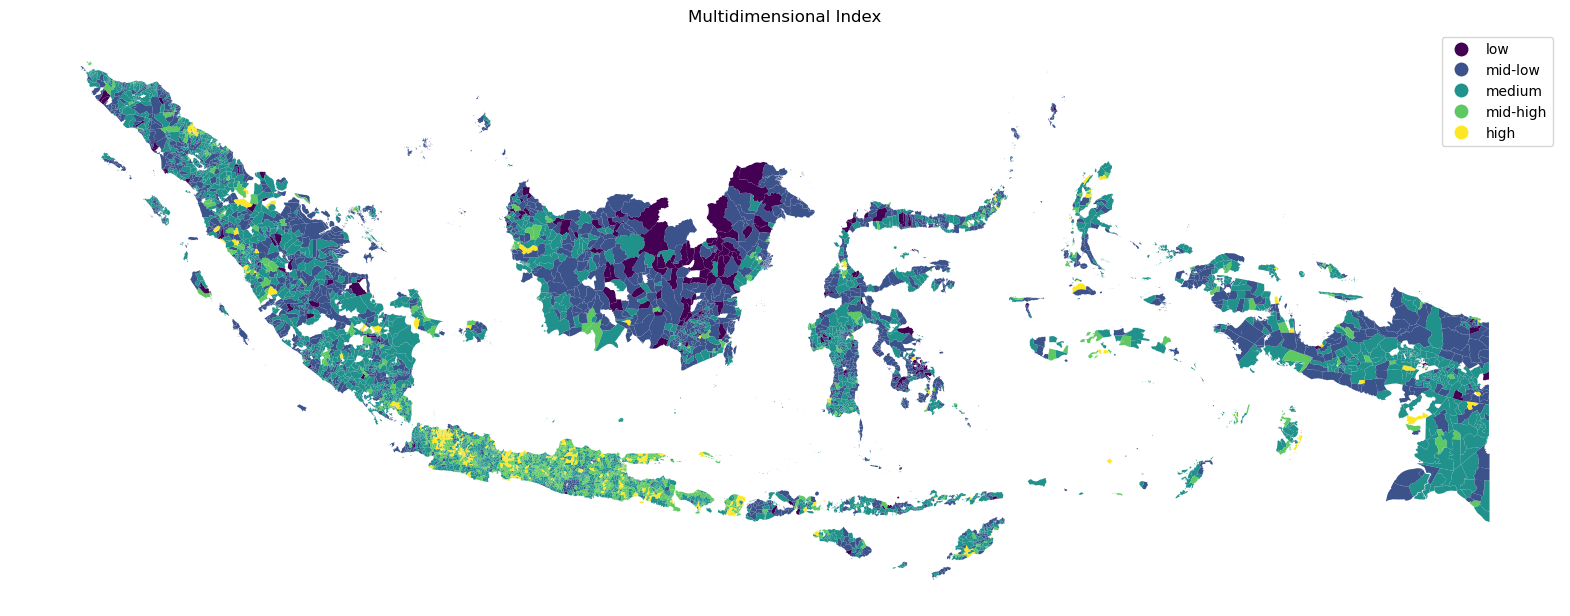

Category Counts:
low          185
mid-low     1850
medium      2867
mid-high    1109
high         435
Name: category, dtype: int64


In [144]:
# Define the standard deviation and mean
std_dev = multidimension_df['multidimensional_index'].std()
mean = multidimension_df['multidimensional_index'].mean()

# Define the category thresholds
thresholds = [-float("inf"), mean - 1.5 * std_dev, mean - 0.5 * std_dev, mean + 0.5 * std_dev, mean + 1.5 * std_dev, float("inf")]

# Define category labels
labels = ['low', 'mid-low', 'medium', 'mid-high', 'high']

# Categorize the data
multidimension_df['category'] = pd.cut(multidimension_df['multidimensional_index'], bins=thresholds, labels=labels)

# Count the number of occurrences for each category
category_counts = multidimension_df['category'].value_counts()
category_counts = category_counts[['low', 'mid-low', 'medium', 'mid-high', 'high']]

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
multidimension_df.plot(column='category', cmap='viridis', legend=True, ax=ax)
plt.title('Multidimensional Index')
plt.axis('off')
plt.show()

print("Category Counts:")
print(category_counts)

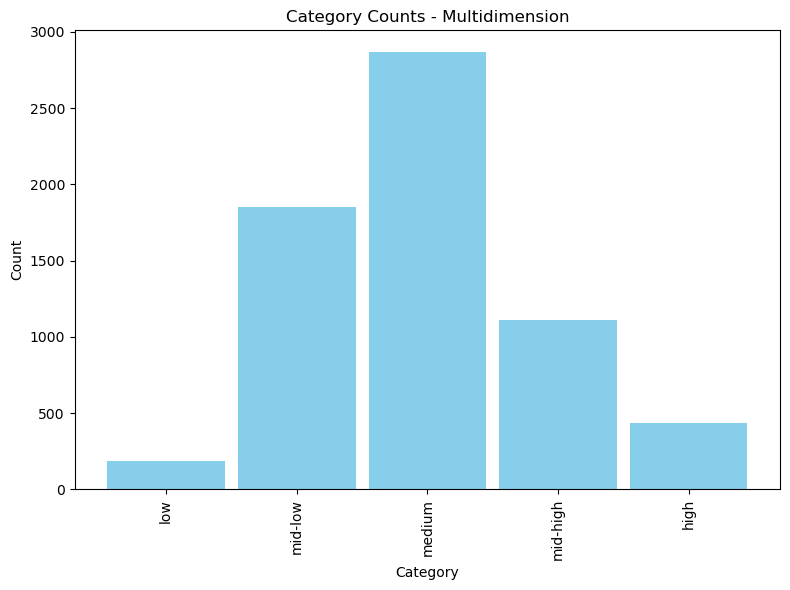

In [145]:
# Creating subplots
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plotting category counts
category_counts.plot(kind='bar', color='skyblue', ax=ax1, width=0.9)  # Adjust the width to make bars stick to each other
ax1.set_title('Category Counts - Multidimension')
ax1.set_xlabel('Category')
ax1.set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()